This notebook is a quick tutorial on how to use inference triage model on emotion dataset. 
This notebook is based on the code `python run_code/load_emotion.py` for generating training and test dataset followed by `python run_code/emotion.py` for running BabyBear algorithm. Please refer to the code available in `run_code/` for other datasets.

All the dataset in this study is taken from huggingface, except `sentiment analysis`. You can find the dataset for this classifier at `data/sentiment/raw_data/`.

## Emotion dataset

This notebook is to generate the results on [emotion dataset](https://huggingface.co/datasets/emotion) taken from hugging face. The model in this work is [bhadresh-savani/bert-base-uncased-emotion](https://huggingface.co/bhadresh-savani/bert-base-uncased-emotion).

#### Import packages

In [16]:

import sys
sys.path.append('../src/')
import util_funcs as uf
import matplotlib.pyplot as plt
import numpy as np
import tensorflow_hub as hub
from nlx_babybear import RFBabyBear
from inference_triage import MamabearClassifierEmotion, TriagedClassifier
import pickle as pkl
import decimal
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

dataset = 'emotion' # Name of dataset
device = -1  # by default device=0, which will run it on cuda. Please define it as -1 if you want to run it on cpu.

#### Loading the data

In [9]:
train, dev, test = uf.load_data(dataset)

text_train , y_train = uf.find_x_y_emotion(train, device=device)
# uf.save_pkl('../data/emotion/train_emotion.pkl', text_train, y_train)  # save the train dataset

text_test , y_test = uf.find_x_y_emotion(test, device=device)
# uf.save_pkl('../data/emotion/test_emotion.pkl', text_test, y_test)  # save the test dataset

Using custom data configuration default
Reusing dataset emotion (/Users/leilakhalili/.cache/huggingface/datasets/emotion/default/0.0.0/348f63ca8e27b3713b6c04d723efe6d824a56fb3d1449794716c0f0296072705)
Using custom data configuration default
Reusing dataset emotion (/Users/leilakhalili/.cache/huggingface/datasets/emotion/default/0.0.0/348f63ca8e27b3713b6c04d723efe6d824a56fb3d1449794716c0f0296072705)
Using custom data configuration default
Reusing dataset emotion (/Users/leilakhalili/.cache/huggingface/datasets/emotion/default/0.0.0/348f63ca8e27b3713b6c04d723efe6d824a56fb3d1449794716c0f0296072705)


There are 6 classes in this dataset (0:"sadness", 1:'joy', 2:'love', 3:'anger', 4:'fear', 5:'surprise'). The distribution of these classes in the training dataset is shown in the following figure.

Text(0.5, 1.0, 'Class distribution on training dataset')

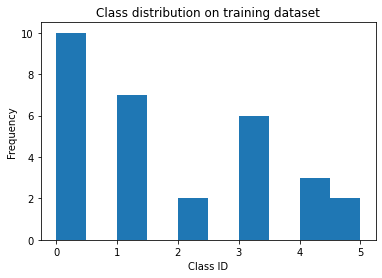

In [10]:

plt.hist(y_train)
plt.xlabel('Class ID')
plt.ylabel('Frequency')
plt.title('Class distribution on training dataset')

#### Input file:

`model`: The model used as [mamabear model]((https://huggingface.co/bhadresh-savani/bert-base-uncased-emotion))

`confidence_th_options`: The values for confidence threshold

`metric`: The metric to find the performance. It can be one of the "accuracy", "recall", "f1_score" and "precision".

`metric_threshold`: The minimum value of performance we are expecting for the final model to have.

In [34]:
model='bhadresh-savani/bert-base-uncased-emotion'
metric = "accuracy"
metric_threshold = .9
confidence_th_options = np.arange(0,1.005,.005)

#### Instantiate babybear and papbear models

In [35]:
language_model = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

mamabear = MamabearClassifierEmotion(model, device=device)
babybear = RFBabyBear(language_model)

inf_traige = TriagedClassifier("classification", babybear, mamabear, metric_threshold, "accuracy", confidence_th_options)

#### hyper-parameter tuning

Here we will train inference triage to find the confidence threshold.


In [ ]:
inf_traige.train(text_train , y_train)

print(f"Confidence threshold is: {inf_traige.confidence_th}")

print(f"The following plots are the saving vs Threshold for different CV fold")



#### Applying inference triage on the test dataset
All the results are also saved in '../output/emotion.resullts'

In [ ]:
inf_triage_predictions = inf_traige.score(text_test , y_test)

In [17]:

dump_data = {}
dump_data['result'] = inf_triage_predictions
dump_data['confidence_th'] = inf_traige.confidence_th
dump_data['indx_conf_th'] = inf_traige.indx_conf_th
dump_data['metric'] = inf_traige.metric
dump_data['metric_threshold'] = inf_traige.metric_threshold
dump_data['performance'] = inf_traige.performance
dump_data['saving'] = inf_traige.saving
dump_data['tot_time'] = inf_traige.tot_time
# with open('../output/emotion.resullts', 'wb') as outp:  # saves the output
#         pkl.dump(dump_data, outp, pkl.HIGHEST_PROTOCOL)

AttributeError: 'dict' object has no attribute 'score'

Plot saving and performance as a function of thresholds

(0.0, 1.0)

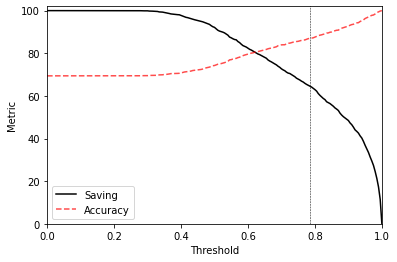

In [33]:
plt.rcParams.update({'font.size': 10})
fig, ax1 = plt.subplots()
# figure(figsize=(7,7))
y = np.arange(-10, 120, 10)
x = len(y)*[confidence_th_options[dump_data['indx_conf_th']]]
plt.plot(confidence_th_options, dump_data['saving'], 'k')

plt.plot(confidence_th_options, np.asarray(dump_data['performance'])*100, '--r', alpha=.7)
plt.plot(x, y, '--',color='k', linewidth=.5)
plt.legend(['Saving', "Accuracy"], loc=3)
plt.xlabel('Threshold')
plt.ylabel('Metric')
plt.ylim([0,102])
plt.xlim([0, 1])


#### Plot cpu/gpu run time!

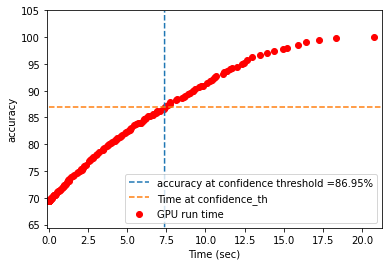

In [18]:

    
plt.scatter(dump_data['tot_time'], np.asarray(dump_data['performance'])*100, color='r', label='GPU run time')
plt.xlabel('Time (sec)')
plt.ylabel(str(dump_data['metric']))

y = np.arange(0, 105, .1)
x = y * 0 + dump_data['tot_time'][dump_data['indx_conf_th']]
plt.plot(x, y, '--', label='accuracy at confidence threshold =' + str(str(dump_data['performance'][dump_data['indx_conf_th']]*100)) + '%')
plt.ylim([min(dump_data['performance'])*100-5, 105])

x = np.arange(-.5, max(dump_data['tot_time'])+.5, .1)
y = x * 0 + dump_data['performance'][dump_data['indx_conf_th']]*100
plt.plot(x, y, '--', label='Time at confidence_th')
plt.xlim([-.1, max(dump_data['tot_time'])+.5])
plt.legend(loc=0)